#  **Deep Neural Networks for Image Classification (Part I)**
#  **Multilayer Perceptron (MLP)**

*   We will create neural networks using Multilayer Perceptrons (MLPs) for classifying CIFAR10 images. We will follow the steps below:
   *  Load (train) CIFAR10 dataset (32x32 RGB images; 10 classes);
   *  Compute mean and standard deviation for data normalization;
   *  Load *normalized* (train and test) CIFAR10 dataset;
   *  Split train set into train and validation sets;
   *  Create iterators for train/test/val sets;
   *  Build the model based on MLP;
   *  Create train/validation/test phases;
   *  Test the model;
   *  Hyper-parameters fine-tuning;
   *  Data augmentation;
   *  Weights initialization.

	• Use the GPU to speed up the training time of you models (Runtime -> Change runtime type -> Hardware accelerator -> GPU).

	• We will use PyTorch. More details at https://pytorch.org/ - https://pytorch.org/tutorials/.  

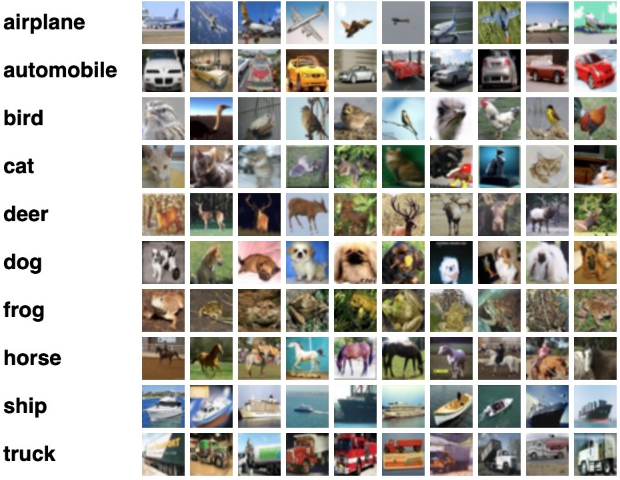

# **MLP/CNN Contest**

*   [Submit results](https://forms.gle/BaYWQshbUjLna1ee6)
*   [Ranking Visualization](https://docs.google.com/spreadsheets/d/13kZPvlRs3H3smuRohcHimaOhmVkJtctp-NW5RJhLTjY/edit?usp=sharing)

*   Load CIFAR-10 dataset

In [ ]:
# Pytorch functions
import torch
# Neural network layers
import torch.nn as nn
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
# Handling dataset
import torch.utils.data as data
# Torchvision library
import torchvision

import matplotlib.pyplot as plt
import random
import numpy as np
import copy
import time
import os
import cv2
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

*  Set "USE_SEED" to False for your own experiments.

In [ ]:
def set_seed(seed, use_gpu = True):
    """
    Set SEED for PyTorch reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_gpu:
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 44

USE_SEED = True

if USE_SEED:
    set_seed(SEED, torch.cuda.is_available())

In [ ]:
# Load CIFAR10 dataset
# Available datasets at https://pytorch.org/vision/stable/datasets.html
ROOT = './data'
train_data = torchvision.datasets.CIFAR10(root=ROOT, train=True, download=True)

# You can also use the 'transform' argument to specify transformations to apply to the dataset
# e.g. 'train_data = torchvision.datasets.CIFAR10(root=ROOT, train=True, download=True, transform=...)'
# See the next steps for applying transformations to a dataset.

Files already downloaded and verified


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
print("-------  DATASET  INFO  --------")
print(train_data)
print()
print(train_data.data.shape)

-------  DATASET  INFO  --------
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train

(50000, 32, 32, 3)


In [ ]:
# Each datapoint is a tuple (image, label)
print("------  DATAPOINT  INFO  ---------")
img = train_data[0][0]
label = train_data[0][1]
print(img) # N_CHANNELS, HEIGHT, WIDTH
print(label)

------  DATAPOINT  INFO  ---------
<PIL.Image.Image image mode=RGB size=32x32 at 0x7C8E3FDA2410>
6


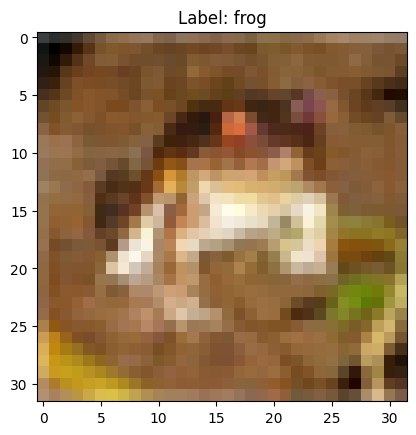

In [ ]:
plt.imshow(img), plt.title("Label: " + classes[label])
plt.show()

*  Data normalization

In [ ]:
# Print min and max rgb values for the 1st image
# You can access the images using the data attribute. The image is stored as a numpy array.
print(f'Image shape: {train_data.data[0].shape}\n')

min_RGB_values = train_data.data[0].min(axis=(0,1))
print(f"Minimum RGB values : {min_RGB_values}")
max_RGB_values = train_data.data[0].max(axis=(0,1))
print(f"Maximum RGB values : {max_RGB_values}")

Image shape: (32, 32, 3)

Minimum RGB values : [0 0 0]
Maximum RGB values : [255 253 235]


*  Data normalization

In [ ]:
# Mean and std should be divided by 255 (maximum pixel value)
# because, after the ToTensor() transformation (see next step), images are normalized
# between 0 and 1.
train_mean = train_data.data.mean(axis=(0,1,2)) / 255
train_std = train_data.data.std(axis=(0,1,2)) / 255

print("-----  TRAIN NORMALIZATION VALUES  -----")
print(f"Mean: {train_mean}")
print(f"Standard Deviation: {train_std}")

-----  TRAIN NORMALIZATION VALUES  -----
Mean: [0.49139968 0.48215841 0.44653091]
Standard Deviation: [0.24703223 0.24348513 0.26158784]


In [ ]:
# Compositions of transformations
# Instead of using PIL images, we will convert them to a Tensor
# which is the data type used by Pytorch.
train_transforms = torchvision.transforms.Compose([
                                                   torchvision.transforms.ToTensor(), # values are normalized between 0 and 1
                                                   torchvision.transforms.Normalize(train_mean, train_std)
])

test_transforms = torchvision.transforms.Compose([
                                                   torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize(train_mean, train_std)
])

In [ ]:
# Load data with transformations
train_data = torchvision.datasets.CIFAR10(root=ROOT,
                                        train=True,
                                        download=True,
                                        transform=train_transforms)

test_data = torchvision.datasets.CIFAR10(root=ROOT,
                                        train=False,
                                        download=True,
                                        transform=test_transforms)
print(train_data)
print(test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
           )


In [ ]:
# Each train/test example ia a tuple (image, label)
# Images are now torch tensors and not numpy arrays (they are very similar)
print("------  DATAPOINT  INFO  ---------")

img = train_data[0][0]
label = train_data[0][1]
print(f"Image size: {img.size()}") # N_CHANNELS, HEIGHT, WIDTH
print(f"Label: {label}")

------  DATAPOINT  INFO  ---------
Image size: torch.Size([3, 32, 32])
Label: 6


In [ ]:
# Let's see if the images are normalized
min_RGB_values = train_data[0][0].amin(dim=(1,2))
print(f"Minimum RGB values : {min_RGB_values}")
max_RGB_values = train_data[0][0].amax(dim=(1,2))
print(f"Maximum RGB values : {max_RGB_values}")

Minimum RGB values : tensor([-1.9892, -1.9802, -1.7070])
Maximum RGB values : tensor([2.0588, 2.0946, 1.8160])


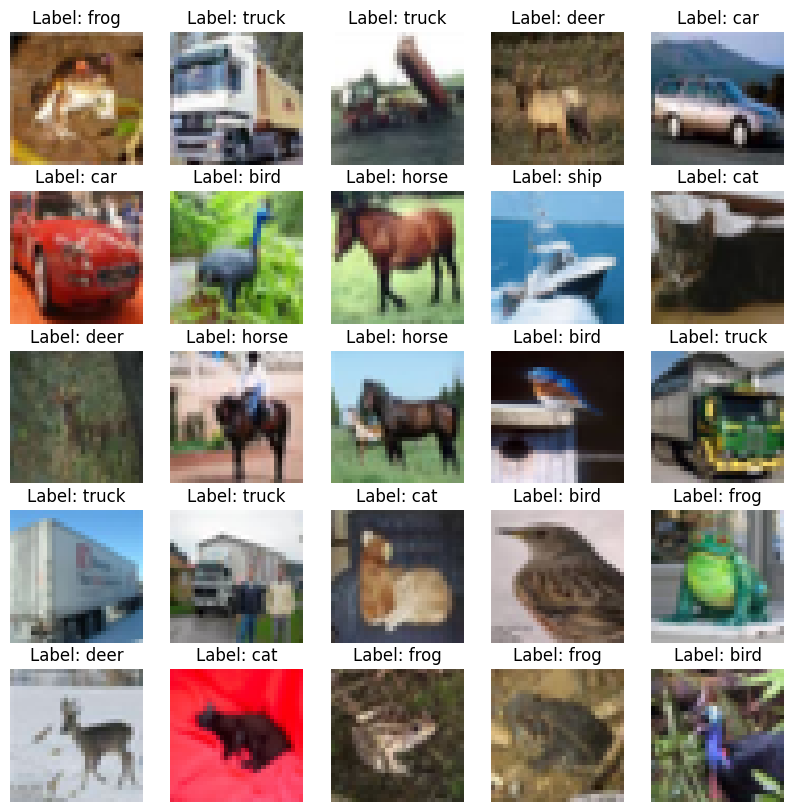

In [ ]:
# Plot some training images
N_IMAGES = 25
plt.figure(figsize=(10, 10))
for i in range(N_IMAGES):
  img = train_data.data[i] # Unnormalized images
  label = train_data[i][1]
  plt.subplot(5,5,i+1), plt.imshow(img), plt.title(f"Label: {classes[label]}"), plt.axis('off')

In [ ]:
# Split train data into train and validation sets
# (10% of training set will be used as validation set)
num_train_examples = int(len(train_data) * 0.90)
num_valid_examples = len(train_data) - num_train_examples

print(f"Number of training examples: {num_train_examples}")
print(f"Number of validation examples: {num_valid_examples}")

Number of training examples: 45000
Number of validation examples: 5000


In [ ]:
# Create 'Subset' objects
train_data, valid_data = data.random_split(train_data, [num_train_examples, num_valid_examples])

print(f"Number training examples: {len(train_data)}")
print(f"Number validation examples: {len(valid_data)}")

Number training examples: 45000
Number validation examples: 5000


In [ ]:
# Apply test transformations to the validation set
valid_data = copy.deepcopy(valid_data) # If we change train transformations, this won't affect the validation set
valid_data.dataset.transform = test_transforms

In [ ]:
# Create iterators
BATCH_SIZE = 256

train_iterator = torch.utils.data.DataLoader(train_data,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data,
                                             batch_size=BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(test_data,
                                            batch_size=BATCH_SIZE)

# How to create a liner layer?

A PyTorch layer can be defined as classes (using the 'nn' package) or as functions (using the 'functional' package). In the following, an example of using the 'nn' package for creating a linear layer.

In [ ]:
# List of pytorch layers available at https://pytorch.org/docs/stable/nn.html
# Input
x = torch.randn((20,20))
# Linear Layer
linear_layer = nn.Linear(400,10) # (in_features, out_features)
# Activation function
relu = nn.ReLU()
Tanh = nn.Tanh()
# Output (apply linear layer and activation function to input values)
y = relu(linear_layer(x.view(20*20))) # view is basically a pytorch reshape

# Print output
print(y.shape)
print(y)

torch.Size([10])
tensor([0.1875, 0.0000, 0.0000, 0.5087, 0.0000, 0.2838, 0.0000, 0.0000, 0.0000,
        0.0000], grad_fn=<ReluBackward0>)


# **MLP**

Let's create a simple MLP network class with three layers with a sigmoid activation function for the hidden layer to classify CIFAR-10 images. The network must inherit from nn.Module and contain a forward method where the input is processed.

---

**Input Layer**: 32 * 32 * 3 = 3072 Units

**Hidden Layer**: 100 Units

**Output Layer**: 10 Units


In [ ]:
# MLP architecture: [3072] -> [100] -> Sigmoid -> [10]

class MLP(nn.Module): # Inherit from PyTorch nn.Module
  def __init__(self, input_dim, output_dim):
    super().__init__()

    # Create two linear layers
    self.fc1 = nn.Linear(input_dim, 100)
    self.fc2 = nn.Linear(100, output_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    batch_size = x.shape[0]
    # Flatten x
    x = x.view(batch_size, -1)
    x = self.fc1(x)
    x = self.Tanh(x) # Apply sigmoid activation function ([ReLU, Tanh, Identity] are other alternatives)


    return x

In [ ]:
# MLP architecture: [3072] -> [100] -> Sigmoid -> [10]

class MLP2(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.5):
        super(MLP2, self).__init__()

        self.fc1 = nn.Linear(input_dim, 100)
        self.fc2 = nn.Linear(100, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))

        return x

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.5):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      batch_size = x.shape[0]
      # Flatten x
      x = x.view(batch_size, -1)
      x = self.fc1(x)
      x = self.sigmoid(x) # Apply sigmoid activation function ([ReLU, Tanh, Identity] are other alternatives)

      return x

*  Alternative network definition using a Sequential container. Use this container if input data is fed sequentially to each layer.

In [ ]:
# # You can also use a sequential container if the data is passed sequentially to each contained layer.
# class MLP(nn.Module):
#   def __init__(self, input_dim, output_dim):
#     super().__init__()

#     self.linear_layers = nn.Sequential(  # Sequential container
#         nn.Linear(input_dim, 100),
#         nn.Sigmoid(),
#         nn.Linear(100, output_dim)
#     )


#   def forward(self, x):
#     batch_size = x.shape[0]
#     # Flatten x
#     x = x.view(batch_size, -1)
#     y = self.linear_layers(x)
#     return y

In [ ]:
INPUT_DIM = 32*32*3 # 32x32x3 images
OUTPUT_DIM = 10 # 10 classes

In [ ]:
# Inizialize the network
model = MLP(INPUT_DIM, OUTPUT_DIM)
print(model)

MLP(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)


*   Let's plot the number of parameters of our network.

In [ ]:
# List of parameters
for name, param in model.named_parameters():
  print(f"{name}, {param.shape}")

fc1.weight, torch.Size([100, 3072])
fc1.bias, torch.Size([100])
fc2.weight, torch.Size([10, 100])
fc2.bias, torch.Size([10])


*   Count the number of parameters

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad) # Count only parameters that are backpropagated

In [ ]:
print(f"The model has {count_parameters(model):,} trainable parameters.")

The model has 308,310 trainable parameters.


* Define Loss and Optimizer

In [ ]:
# Loss
criterion = nn.CrossEntropyLoss() # Softmax + CrossEntropy

# Put model&criterion (loss) on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = criterion.to(device)

In [ ]:
# Optim
optimizer = optim.SGD(model.parameters(), lr=3e-3) # Adam optimizer is an alternative optimizer
#optimizer = optim.Adam(model.parameters(), lr=3e-3) # Adam optimizer is an alternative optimizer
model = model.to(device)

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

# Training/Validation/Testing functions

*   Compute accuracy

In [ ]:
def calculate_accuracy(y_pred, y):
  '''
  Compute accuracy from ground-truth and predicted labels.

  Input
  ------
  y_pred: torch.Tensor [BATCH_SIZE, N_LABELS]
  y: torch.Tensor [BATCH_SIZE]

  Output
  ------
  accuracy: np.float
    Accuracy
  '''

  # Apply softmax (to convert values into probabilities)
  y_prob = F.softmax(y_pred, dim = -1)
  # Consider class with higher probability
  y_pred = y_pred.argmax(dim=1, keepdim = True)
  # Chech if prediction is correct
  correct = y_pred.eq(y.view_as(y_pred)).sum()
  # Compute accuracy (percentage)
  accuracy = correct.float()/y.shape[0]

  return accuracy

*  Training phase

In [ ]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Apply train mode
  model.train()

  for (x,y) in iterator:
    x = x.to(device)
    y = y.to(device)

    # Set gradients to zero
    optimizer.zero_grad()

    # Make Predictions
    y_pred = model(x)

    # Compute loss
    loss = criterion(y_pred, y)

    # Compute accuracy
    acc = calculate_accuracy(y_pred, y)

    # Backprop
    loss.backward()

    # Apply optimizer
    optimizer.step()

    # Extract data from loss and accuracy
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

* Validation/Testing phase

In [ ]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Evaluation mode
  model.eval()

  # Do not compute gradients
  with torch.no_grad():

    for (x,y) in iterator:

      x = x.to(device)
      y = y.to(device)

      # Make Predictions
      y_pred = model(x)

      # Compute loss
      loss = criterion(y_pred, y)

      # Compute accuracy
      acc = calculate_accuracy(y_pred, y)

      # Extract data from loss and accuracy
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

*  Model training

In [ ]:
def model_training(n_epochs, model, train_iterator, valid_iterator, optimizer, criterion, device, model_name='best_model.pt'):

  # Initialize validation loss
  best_valid_loss = float('inf')

  # Save output losses, accs
  train_losses = []
  train_accs = []
  valid_losses = []
  valid_accs = []

  # Loop over epochs
  for epoch in range(n_epochs):
    start_time = time.time()

    # Train
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    # Validation
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    # Save best model
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      # Save model
      torch.save(model.state_dict(), model_name)
    end_time = time.time()

    print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
    print("---------------------------------")
    print(f"Train -- Loss: {train_loss:.3f}, Acc: {train_acc * 100:.2f}%")
    print(f"Val -- Loss: {valid_loss:.3f}, Acc: {valid_acc * 100:.2f}%")

    # Save
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

  return train_losses, train_accs, valid_losses, valid_accs

In [ ]:
N_EPOCHS = 25
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS,
                                                                    model,
                                                                    train_iterator,
                                                                    valid_iterator,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    'mlp.pt')

AttributeError: ignored

In [ ]:
def plot_results(n_epochs, train_losses, train_accs, valid_losses, valid_accs):
  N_EPOCHS = n_epochs
  # Plot results
  plt.figure(figsize=(20, 6))
  _ = plt.subplot(1,2,1)
  plt.plot(np.arange(N_EPOCHS)+1, train_losses, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_losses, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

  _ = plt.subplot(1,2,2)
  plt.plot(np.arange(N_EPOCHS)+1, train_accs, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_accs, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

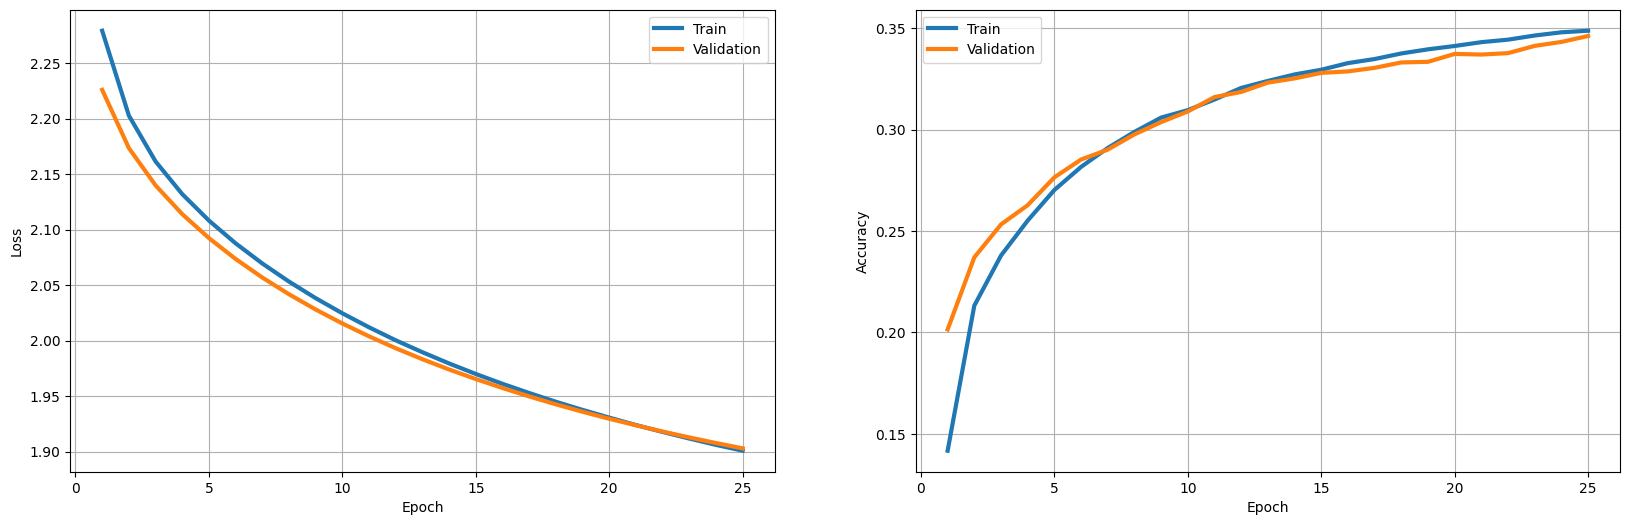

In [ ]:
plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [ ]:
# Test model
def model_testing(model, test_iterator, criterion, device, model_name='best_model.pt'):
  # Load best weights
  model.load_state_dict(torch.load(model_name))
  # Evaluate model
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
  # Print results
  print(f"Test -- Loss: {test_loss:.3f}, Acc: {test_acc * 100:.2f} %")

In [ ]:
model_testing(model, test_iterator, criterion, device, 'mlp.pt')

Test -- Loss: 1.898, Acc: 34.98 %


*  Confusion matrix and classification report

In [ ]:
def predict(model, iterator, device):

  # Evaluation mode
  model.eval()

  labels = []
  pred = []

  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred = model(x)

      # Get label with highest score
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim=True)

      labels.append(y.cpu())
      pred.append(top_pred.cpu())

  labels = torch.cat(labels, dim=0)
  pred = torch.cat(pred, dim=0)

  return labels, pred


In [ ]:
def print_report(model, test_iterator, device):
  labels, pred = predict(model, test_iterator, device)
  print(confusion_matrix(labels, pred))
  print("\n")
  print(classification_report(labels, pred))

In [ ]:
print_report(model, test_iterator, device)

[[478  48  29  16  14  20  30  49 240  76]
 [ 46 409  22  33  19  32  80  32 121 206]
 [146  54 142  64 171  91 175  70  55  32]
 [ 56  95  76 167  53 220 143  86  41  63]
 [ 60  48  92  52 302  65 219 100  34  28]
 [ 48  55  86  95  66 353 132  80  61  24]
 [ 16  66  68  80 105  90 478  45  15  37]
 [ 58  60  53  42 117  77  87 359  46 101]
 [128  85   9  21   5  50   3  19 550 130]
 [ 50 164  13  23  10  17  47  47 133 496]]


              precision    recall  f1-score   support

           0       0.44      0.48      0.46      1000
           1       0.38      0.41      0.39      1000
           2       0.24      0.14      0.18      1000
           3       0.28      0.17      0.21      1000
           4       0.35      0.30      0.32      1000
           5       0.35      0.35      0.35      1000
           6       0.34      0.48      0.40      1000
           7       0.40      0.36      0.38      1000
           8       0.42      0.55      0.48      1000
           9       0.42   

*  Plot the weights to check if a neuron has learned to look for specific patterns in the input.

In [ ]:
def normalize_image(image):
  image = torch.clamp(image, min = image.min(), max = image.max())
  image = torch.add(image, -image.min()).div_(image.max() - image.min() + 1e-5)
  return image

Weights shape: torch.Size([100, 3072])


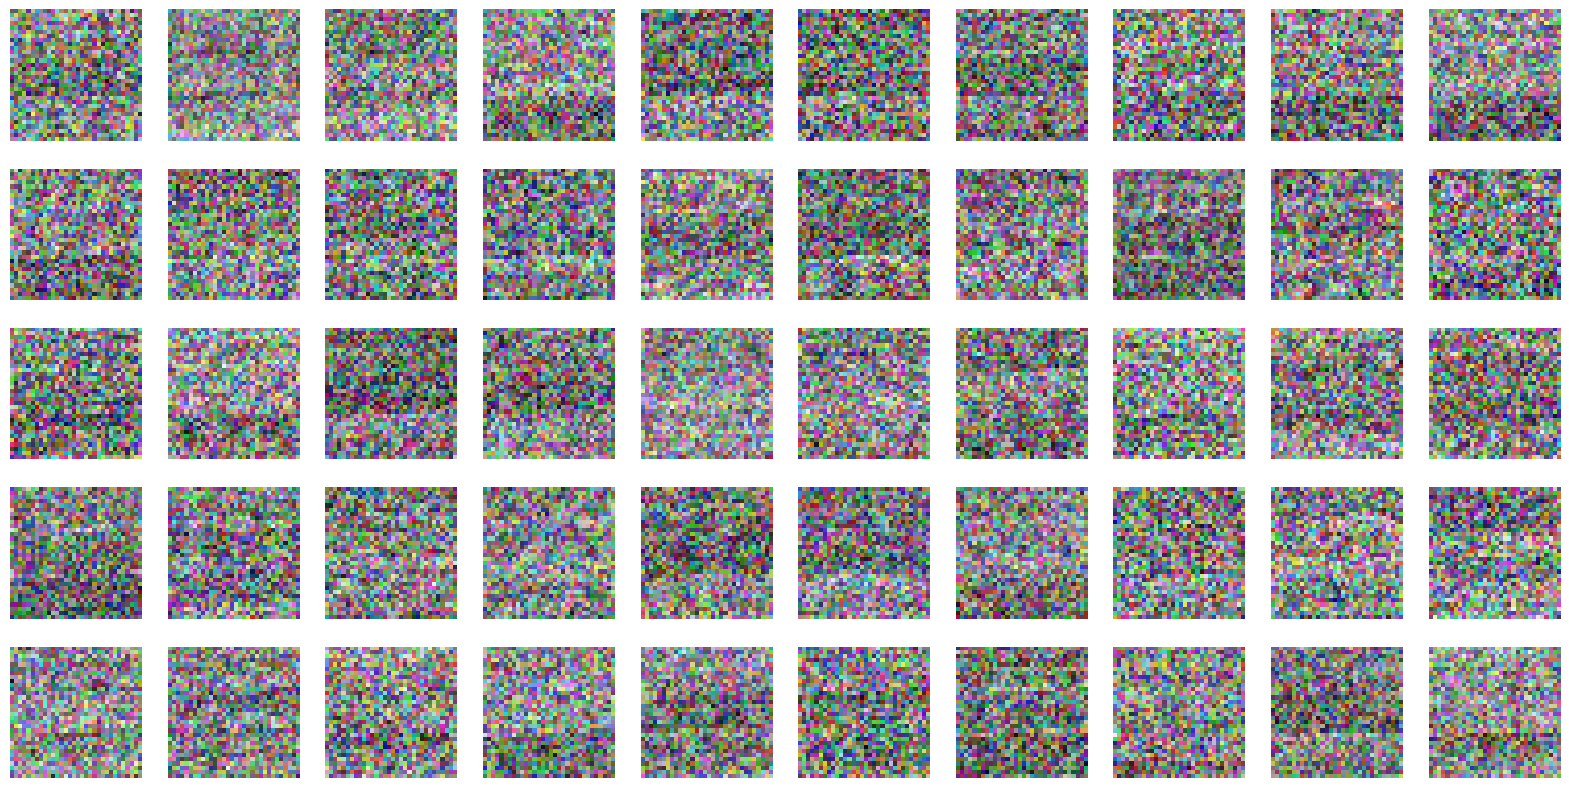

In [ ]:
# Plot weights
weights = model.fc1.weight.data
print(f"Weights shape: {weights.shape}")
plt.figure(figsize=(20, 10))
for i in range(50):
  plt.subplot(5, 10, i+1), plt.imshow(normalize_image(weights[i].view(32,32,3)).cpu().numpy())
  plt.axis('off')

# **Data augmentation**

* Pytorch transformations are available at https://pytorch.org/vision/stable/transforms.html.

In [ ]:
# Apply random rotation + horizontal flipping
# Composition of transformations
train_transforms = torchvision.transforms.Compose([
                                                   torchvision.transforms.RandomRotation(15),
                                                   torchvision.transforms.RandomHorizontalFlip(p=0.6),
                                                   # torchvision.transforms.ColorJitter(),
                                                   # torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
                                                   # torchvision.transforms.RandomVerticalFlip(),
                                                   torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize(train_mean, train_std)
])

In [ ]:
train_data.dataset.transform = train_transforms

train_iterator = torch.utils.data.DataLoader(train_data,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE)

# Create new model
model = MLP(INPUT_DIM, OUTPUT_DIM)

optimizer = optim.SGD(model.parameters(), lr=5e-3)
model = model.to(device)

In [ ]:
N_EPOCHS = 1
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS,
                                                                    model,
                                                                    train_iterator,
                                                                    valid_iterator,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    'mlp_data_aug.pt')


Epoch: 1/25 -- Epoch Time: 21.20 s
---------------------------------
Train -- Loss: 2.229, Acc: 20.96%
Val -- Loss: 2.156, Acc: 26.50%

Epoch: 2/25 -- Epoch Time: 21.94 s
---------------------------------
Train -- Loss: 2.126, Acc: 27.65%
Val -- Loss: 2.086, Acc: 29.27%

Epoch: 3/25 -- Epoch Time: 21.95 s
---------------------------------
Train -- Loss: 2.069, Acc: 29.52%
Val -- Loss: 2.039, Acc: 30.59%

Epoch: 4/25 -- Epoch Time: 21.16 s
---------------------------------
Train -- Loss: 2.028, Acc: 30.91%
Val -- Loss: 2.004, Acc: 31.25%

Epoch: 5/25 -- Epoch Time: 21.76 s
---------------------------------
Train -- Loss: 1.996, Acc: 31.56%
Val -- Loss: 1.977, Acc: 32.13%

Epoch: 6/25 -- Epoch Time: 21.48 s
---------------------------------
Train -- Loss: 1.971, Acc: 32.39%
Val -- Loss: 1.955, Acc: 32.81%

Epoch: 7/25 -- Epoch Time: 21.42 s
---------------------------------
Train -- Loss: 1.950, Acc: 32.93%
Val -- Loss: 1.937, Acc: 33.49%

Epoch: 8/25 -- Epoch Time: 21.89 s
------------

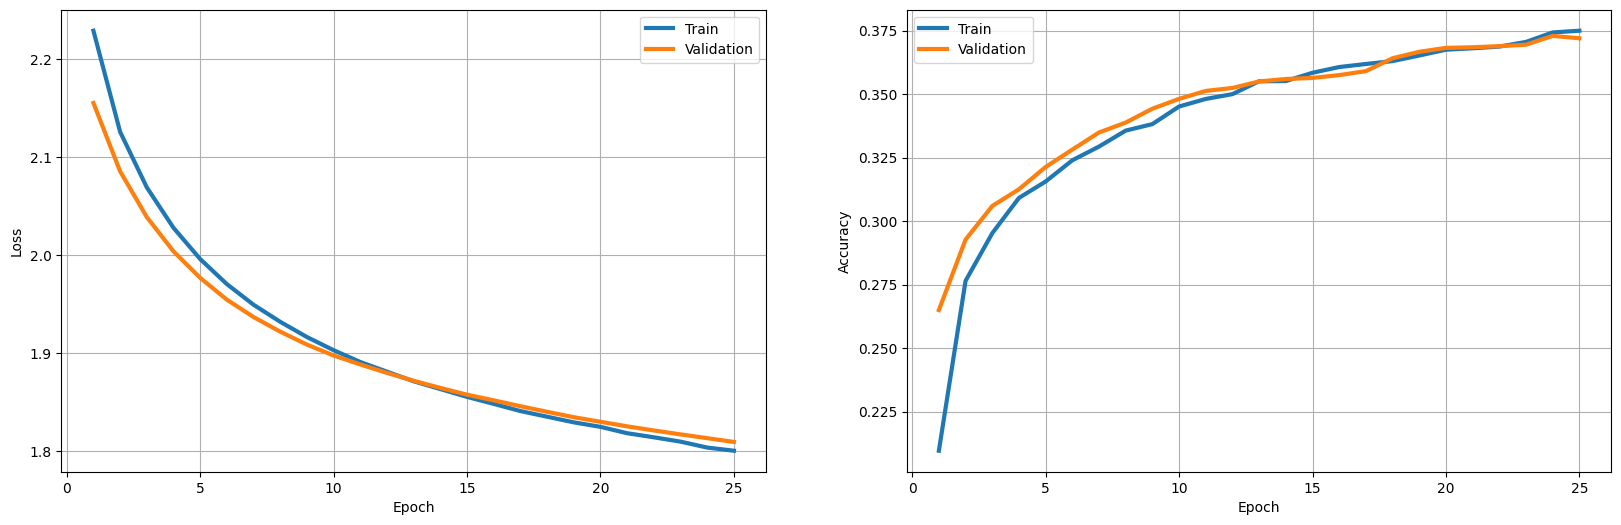

In [ ]:
plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [ ]:
model_testing(model, test_iterator, criterion, device, 'mlp_data_aug.pt')

Test -- Loss: 1.795, Acc: 37.06 %


In [ ]:
print_report(model, test_iterator, device)

[[449  62  22  14   7  13  32  60 269  72]
 [ 50 437  14  20  13  35  58  34 134 205]
 [160  71 109  56 141  76 163 124  56  44]
 [ 57 100  54 174  36 200 132 104  52  91]
 [ 61  62  79  53 269  46 215 139  37  39]
 [ 47  72  53  99  57 316 120 119  76  41]
 [ 22  72  42  71  97  85 474  53  16  68]
 [ 54  68  40  41  97  59  71 419  51 100]
 [114  81   4  19   5  38   4  24 573 138]
 [ 51 159   7  16   8  15  43  38 148 515]]


              precision    recall  f1-score   support

           0       0.42      0.45      0.43      1000
           1       0.37      0.44      0.40      1000
           2       0.26      0.11      0.15      1000
           3       0.31      0.17      0.22      1000
           4       0.37      0.27      0.31      1000
           5       0.36      0.32      0.34      1000
           6       0.36      0.47      0.41      1000
           7       0.38      0.42      0.40      1000
           8       0.41      0.57      0.48      1000
           9       0.39   

# **Weights Initialization**

Weights initialization methods are available at https://pytorch.org/docs/stable/nn.init.html


In [ ]:
# Define a method for weights initialization
def weights_init(model):
    if isinstance(model, nn.Linear):
        nn.init.uniform_(model.weight.data, -0.02, 0.02) # [zeros_, normal_, xavier_uniform_, xavier_normal_]
        nn.init.constant_(model.bias, 0.01)

In [ ]:
model = MLP(INPUT_DIM, OUTPUT_DIM)
optimizer = optim.SGD(model.parameters(), lr=5e-3)
model = model.to(device)

In [ ]:
# Apply initialization
model.apply(weights_init)

MLP(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# Weights Initialization + Data Augmentation
N_EPOCHS = 25
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS,
                                                                    model,
                                                                    train_iterator,
                                                                    valid_iterator,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    'mlp_new_weights.pt')


Epoch: 1/25 -- Epoch Time: 31.35 s
---------------------------------
Train -- Loss: 2.291, Acc: 16.92%
Val -- Loss: 2.275, Acc: 21.32%

Epoch: 2/25 -- Epoch Time: 24.98 s
---------------------------------
Train -- Loss: 2.260, Acc: 22.07%
Val -- Loss: 2.235, Acc: 23.60%

Epoch: 3/25 -- Epoch Time: 21.71 s
---------------------------------
Train -- Loss: 2.218, Acc: 23.30%
Val -- Loss: 2.189, Acc: 24.24%

Epoch: 4/25 -- Epoch Time: 22.10 s
---------------------------------
Train -- Loss: 2.173, Acc: 24.18%
Val -- Loss: 2.147, Acc: 25.02%

Epoch: 5/25 -- Epoch Time: 22.61 s
---------------------------------
Train -- Loss: 2.133, Acc: 25.51%
Val -- Loss: 2.111, Acc: 26.48%

Epoch: 6/25 -- Epoch Time: 21.79 s
---------------------------------
Train -- Loss: 2.099, Acc: 26.31%
Val -- Loss: 2.080, Acc: 27.52%

Epoch: 7/25 -- Epoch Time: 22.32 s
---------------------------------
Train -- Loss: 2.070, Acc: 27.04%
Val -- Loss: 2.054, Acc: 28.07%


KeyboardInterrupt: ignored

In [ ]:
plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [ ]:
model_testing(model, test_iterator, criterion, device, 'mlp_new_weights.pt')

In [ ]:
print_report(model, test_iterator, device)

Let's create a different architecture using dropout, Adam optimizer and a different linear layers' initialization.

In [ ]:
# Previous data augmentation is applied
# MLP architecture:
# [3072] -> [1500] -> ReLU -> Dropout(0.3) -> [750] -> ReLU -> Dropout(0.1) -> [300] -> ReLU -> Dropout(0.2) -> [10]

def weights_init(model):
    if isinstance(model, nn.Linear):
        nn.init.kaiming_normal_(model.weight.data)
        nn.init.constant_(model.bias, 0.01)

class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()

    self.linear_layers = nn.Sequential(
        nn.Linear(input_dim, 1500),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1500, 750),
        nn.ReLU(),
        nn.Linear(750, 300),
        nn.ReLU(),
        nn.Linear(300, 150),
        nn.ReLU(),
        nn.Linear(150, output_dim)
    )

  def forward(self, x):
    batch_size = x.shape[0]
    # Flatten x
    x = x.view(batch_size, -1)
    # Apply linear
    out = self.linear_layers(x)

    return out

model = MLP(INPUT_DIM, OUTPUT_DIM)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
model = model.to(device)


# Apply initialization
model.apply(weights_init)

# Weights Initialization + Data Augmentation
N_EPOCHS = 25
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS,
                                                                    model,
                                                                    train_iterator,
                                                                    valid_iterator,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    model_name='final_mlp.pt')

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)
model_testing(model, test_iterator, criterion, device, model_name='final_mlp.pt')
print_report(model, test_iterator, device)

In [ ]:
# Plot weights
weights = model.linear_layers[0].weight.data
print(f"Weights shape: {weights.shape}")
plt.figure(figsize=(20, 10))
for i in range(50):
  plt.subplot(5, 10, i+1), plt.imshow(normalize_image(weights[i*10].view(32,32,3)).cpu().numpy())
  plt.axis('off')

# **MLP Contest**

Previous networks do not perform well on CIFAR-10 dataset. Design your own architecture (based on MLPs) and set the corresponding hyper-parameters in order to achieve better performance on the test set. Some parameters to focus on are listed below:

#### *Network's parameters*:

- Number of layers;
- Number of neurons per layer;
- Activation functions;
- Weights initialization;
- Dropout Rate.

#### *Training parameters*:
- Learning rate;
- Number of epochs;
- Optimizer;
- Batch size.

#### *Data*:
- Data augmentation.

You can also use different training techniques (e.g., early stopping, LR schedule) or consider ensemble methods.